<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split


# for dirname, _, filenames in os.walk('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

# Preprocessing

## Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [3]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


### Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [5]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [6]:
fraud = (data['isFraud'] == 1).sum()
safe = (data['isFraud'] == 0).sum()
ratio = np.ceil(safe/fraud)

## One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [7]:
data = pd.get_dummies(data)

In [8]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [9]:
data = mf.select_days(data, 60)

## Time scaling

In [10]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
time = data['TransactionDT'].values.reshape(-1,1)
data['TransactionDT'] = min_max_scaler.fit_transform(time)

## Train validation test split

In [11]:
data.drop(columns=['TransactionID'], inplace=True)

Splitto il dataset in train, validation e test set. 

In [12]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Undersampling: Easy Ensemble

L'easy ensemble tramite un metodo unsupervised divide il dataset in diversi dataset undersampled. 

Documentazione easy ensemble: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.ensemble.EasyEnsemble.html#imblearn.ensemble.EasyEnsemble

Esempio applicazio ee: http://glemaitre.github.io/imbalanced-learn/auto_examples/ensemble/plot_easy_ensemble.html?highlight=easy%20ensemble

In [13]:
# X_trainres, y_trainres = mf.easy_ensemble(5, X_train, y_train)

# Neural Network

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

keras.backend.clear_session()

model = Sequential()
model.add(Input(shape=(X_train.shape[1],))) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(24, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2699264   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    # X_trainres[0], y_trainres[0],    
    X_train, y_train,
    epochs=20, #20
    batch_size=1000, # 1000
    validation_data=(X_val,y_val),
    # validation_data=(X_trainres[1],y_trainres[1]),
    verbose=1,
    shuffle = True , #class_weight = {0: 1, 1: ratio / 2}
)

Epoch 1/20
133/133 [==============================] - 6s 30ms/step - loss: 0.2944 - accuracy: 0.9418 - val_loss: 0.1185 - val_accuracy: 0.9695
Epoch 2/20
133/133 [==============================] - 3s 20ms/step - loss: 0.2222 - accuracy: 0.9680 - val_loss: 0.1068 - val_accuracy: 0.9695
Epoch 3/20
133/133 [==============================] - 3s 20ms/step - loss: 0.2051 - accuracy: 0.9697 - val_loss: 0.1070 - val_accuracy: 0.9728
Epoch 4/20
133/133 [==============================] - 3s 20ms/step - loss: 0.1909 - accuracy: 0.9719 - val_loss: 0.0999 - val_accuracy: 0.9735
Epoch 5/20
133/133 [==============================] - 3s 19ms/step - loss: 0.1823 - accuracy: 0.9721 - val_loss: 0.0967 - val_accuracy: 0.9737
Epoch 6/20
133/133 [==============================] - 3s 19ms/step - loss: 0.1709 - accuracy: 0.9734 - val_loss: 0.1050 - val_accuracy: 0.9742
Epoch 7/20
133/133 [==============================] - 3s 19ms/step - loss: 0.1624 - accuracy: 0.9735 - val_loss: 0.0963 - val_accuracy: 0.9746

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

1381/1381 [==============================] - 3s 2ms/step - loss: 0.0866 - accuracy: 0.9772

Test Loss:	 0.08655326068401337
Test Accuracy:	 0.9772197008132935


In [18]:
y_pred = model.predict(X_test)

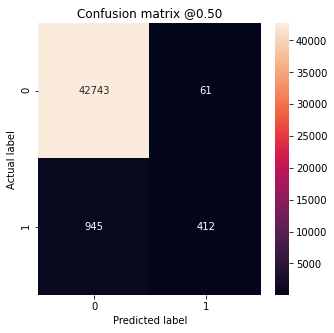

In [19]:
mf.plot_cm(y_test, y_pred)

AUC:  0.8827561209060621


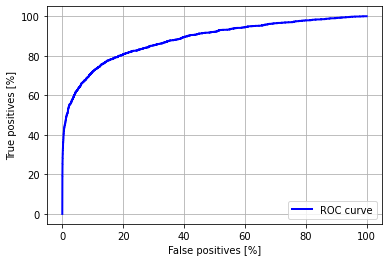

In [20]:
mf.plot_roc("ROC curve", y_test, y_pred,color='blue')

Average precision:  0.5286120357196432


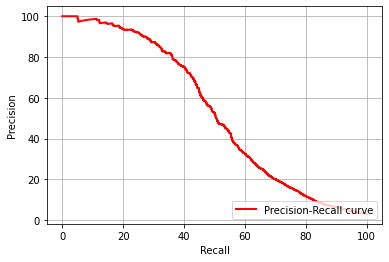

In [21]:
mf.plot_ap('Precision-Recall curve', y_test, y_pred, color = 'red')